In [1]:
import math
import numpy as np
import seaborn as sns
import torch
import os
import skimage
import matplotlib.pyplot as plt
import scipy

# Load from saved explanations

In [2]:
SAVED_EXPLANATIONS_DIR = os.path.join('explanations', 'random')
SAVED_EXPLANATIONS_DIR

'explanations\\random'

In [3]:
blackboxes = ['InceptionV3', 'ResNet']
explanations = dict()
methods = set()

for blackbox in blackboxes:
    explanations[blackbox] = dict()
    
    directory = os.path.join(SAVED_EXPLANATIONS_DIR, blackbox)
    for file in os.listdir(directory):
        method = os.path.basename(file).split('.')[0]
        methods.add(method)

        path = os.path.join(directory, file)
        exp = torch.load(path)

        explanations[blackbox][method] = exp

methods = list(methods)
methods.sort()
print(f'Blackboxes: {blackboxes}')
print(f'Methods: {methods}')

Blackboxes: ['InceptionV3', 'ResNet']
Methods: ['DeepLift', 'GradientShap', 'GuidedBackprop', 'GuidedGradCam', 'IntegratedGradients', 'LRP', 'Occlusion', 'Saliency']


# Metrics

## Metrics from the paper _The Disagreement Problem in Explainable Machine Learning_

In [4]:
def feature_agreement(x, y, k=1638):
    _, i1 = torch.topk(torch.Tensor(x).flatten().abs(), k)
    _, i2 = torch.topk(torch.Tensor(y).flatten().abs(), k)
    i1 = set(torch.unique(i1).tolist())
    i2 = set(torch.unique(i2).tolist())
    intersect = len(i1.intersection(i2))
    return 1.0 * intersect / k

In [5]:
def sign_agreement(x, y, k=1638):
    x_flatten = x.flatten()
    y_flatten = y.flatten()
    x_topk = np.argpartition(np.absolute(x_flatten), -k)[-k:]
    y_topk = np.argpartition(np.absolute(y_flatten), -k)[-k:]
    
    intersect = np.intersect1d(x_topk, y_topk)
    same_sign = np.asarray(list(map(lambda ind: np.sign(x_flatten[ind]) == np.sign(y_flatten[ind]), intersect)))
    return same_sign.sum() * 1.0 / k

In [6]:
def rank_correlation(x, y):
    return scipy.stats.spearmanr(x.flatten().abs(), y.flatten().abs()).correlation


## Structural Similarity Index

In [7]:
def ssim(x, y):
    return skimage.metrics.structural_similarity(normalize(np.abs(x)), normalize(np.abs(y)), data_range=1.0)

In [8]:
def emd(x, y):
    return scipy.stats.wasserstein_distance(normalize(np.abs(x)).flatten(), normalize(np.abs(y)).flatten())

# Computing disagreement and visualizing

In [9]:
def normalize(x):
    t = (x - np.min(x)) / (np.max(x) - np.min(x))
    return t

In [10]:
def normalize_sum_to_one(x):
    norm = normalize(x)
    return norm / norm.sum()

In [11]:
def compute_mean_disagreement(exp1, exp2, metric, **options):
    metrics = []
    has_nan = lambda x: isinstance(x, np.ndarray) and np.isnan(x).any()
    if has_nan(exp1) or has_nan(exp2):
        return float('nan')
    for e1, e2 in zip(exp1, exp2):
        metrics.append(metric(e1, e2, **options))
    return np.array(metrics).mean()

In [12]:
# Compute disagreement heatmap for one blackbox
def compute_heatmap(methods, explanations, metric, **options):
    size = len(methods)
    result = dict()
    result['data'] = np.empty((size, size))
    result['methods'] = methods

    for j in range(size):
        for i in range(size):
            exp1 = explanations[methods[i]]
            exp2 = explanations[methods[j]]
            
            if isinstance(exp1, torch.Tensor):
                exp1 = exp1.cpu().numpy()
            
            if isinstance(exp2, torch.Tensor):
                exp2 = exp2.cpu().numpy()
            
            if i >= j:
                result['data'][i, j] = compute_mean_disagreement(exp1, exp2, metric, **options)
            else:
                result['data'][i, j] = result['data'][j, i]
    return result

In [13]:
def compute_heatmaps(explanations, metric, **options):
    result = dict()
    for k, v in explanations.items():
        methods = list(v.keys())
        methods.sort()
        result[k] = compute_heatmap(methods, v, metric, **options)
    return result

In [14]:
def visualize(hm, title='', ax=None, **options):
    return sns.heatmap(
        hm,
        annot=True,
        ax=ax,
        **options
    ).set(title=title)

In [15]:
def visualize_many(heatmaps, metric_name='', **options):
    num_black_boxes = len(heatmaps.keys())
    fig, axes = plt.subplots(nrows=1, ncols=num_black_boxes, figsize=(18,6))
    
    if num_black_boxes == 1:
        axes = [axes]
    
    for i, blackbox in enumerate(heatmaps.keys()):
        heatmap_dict = heatmaps[blackbox]
        methods = heatmap_dict['methods']
        data = heatmap_dict['data']
        
        # Plot
        sns.heatmap(
            data,
            annot=True,
            ax=axes[i],
            xticklabels=methods,
            yticklabels=methods,
            **options
        ).set(title=blackbox)
        axes[i].tick_params(left=False, bottom=False)
    
    fig.suptitle(metric_name)
    return fig, axes

In [16]:
def get_top_k(exp, k):
    _, top = torch.topk(exp.flatten().abs(), k)
    old_size = exp.size()
    result = torch.zeros(exp.nelement())
    result[top] = 1
    result = result.reshape(old_size).bool()
    return result

## Feature Agreement

In [17]:
%%time
heatmap_fa = compute_heatmaps(explanations, metric=feature_agreement, k=int(128 * 128 * 0.1))

CPU times: total: 2.11 s
Wall time: 3 s


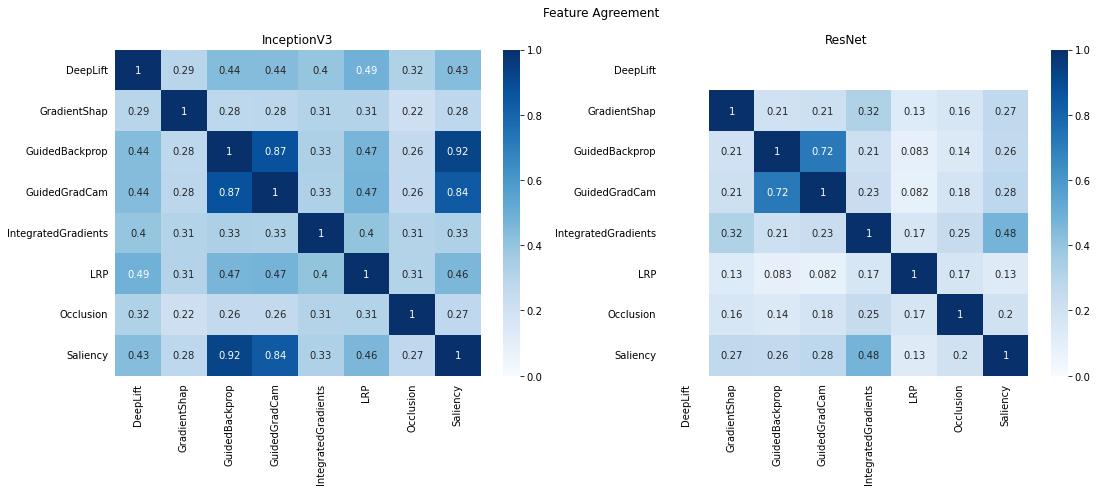

In [18]:
options = {
    'vmin': 0,
    'vmax': 1,
    'cmap': 'Blues'
}

fig_fa, axes_fa = visualize_many(heatmap_fa, metric_name='Feature Agreement', **options)
fig_fa.savefig('figures/feature-agreement', bbox_inches='tight')
plt.show()

## Sign Agreement

In [19]:
%%time
heatmap_sa = compute_heatmaps(explanations, metric=sign_agreement)

CPU times: total: 3.45 s
Wall time: 4.81 s


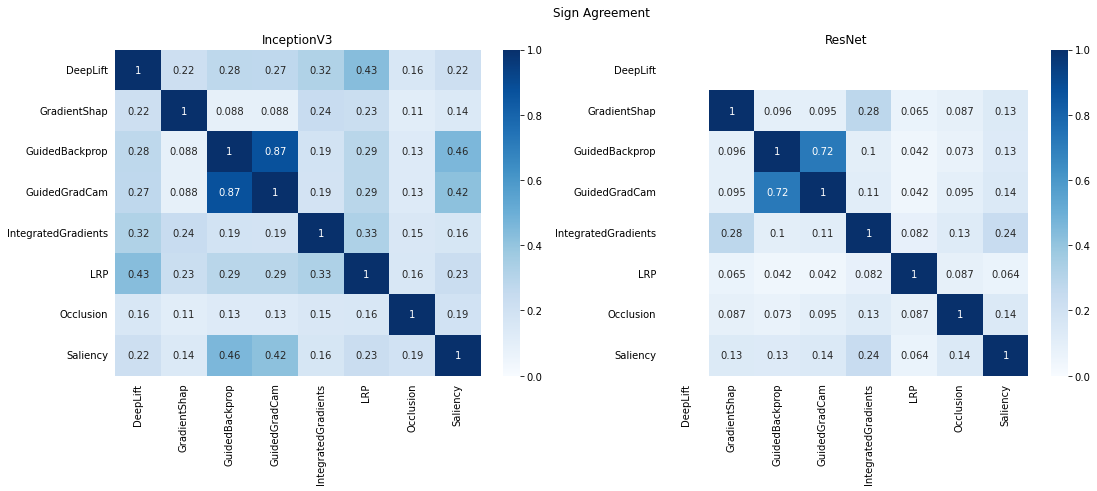

In [20]:
fig_sa, axes_as = visualize_many(heatmap_sa, metric_name='Sign Agreement', **options)
fig_sa.savefig('figures/sign-agreement', bbox_inches='tight')
plt.show()

## Rank correlation

In [21]:
x = torch.load('sampled_input/images.pt')
masks = torch.load('sampled_input/masks.pt')

In [22]:
explanations_masked = dict()
masks_flatten = masks.flatten(1).bool()
for blackbox, v in explanations.items():
    explanations_masked[blackbox] = dict()
    
    for method in methods:
        exp = v[method]
        
        masked_explanations = []
        for i, e in enumerate(exp):
            mask = masks_flatten[i]
            if mask.sum() == 0:
                continue
            masked_explanation = e.flatten()[mask]
            masked_explanations.append(masked_explanation)
        explanations_masked[blackbox][method] = masked_explanations

In [23]:
%%time
heatmap_rc = compute_heatmaps(explanations_masked, metric=rank_correlation)

CPU times: total: 656 ms
Wall time: 156 ms


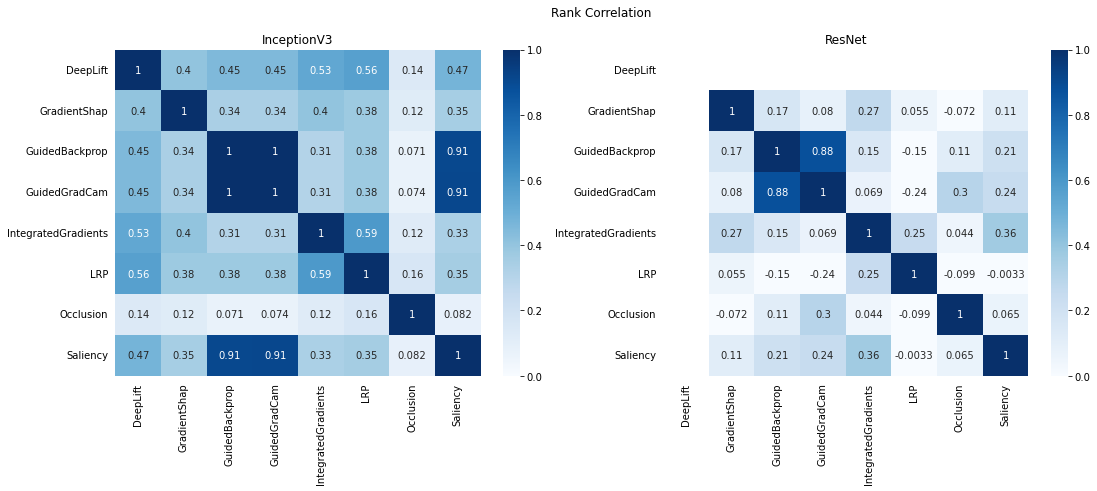

In [24]:
fig_rc, _ = visualize_many(heatmap_rc, metric_name='Rank Correlation', **options)
fig_rc.savefig('figures/rank-correlation', bbox_inches='tight')
plt.show()

## SSIM

In [25]:
%%time
heatmap_ssim = compute_heatmaps(explanations, metric=ssim)

CPU times: total: 953 ms
Wall time: 1.58 s


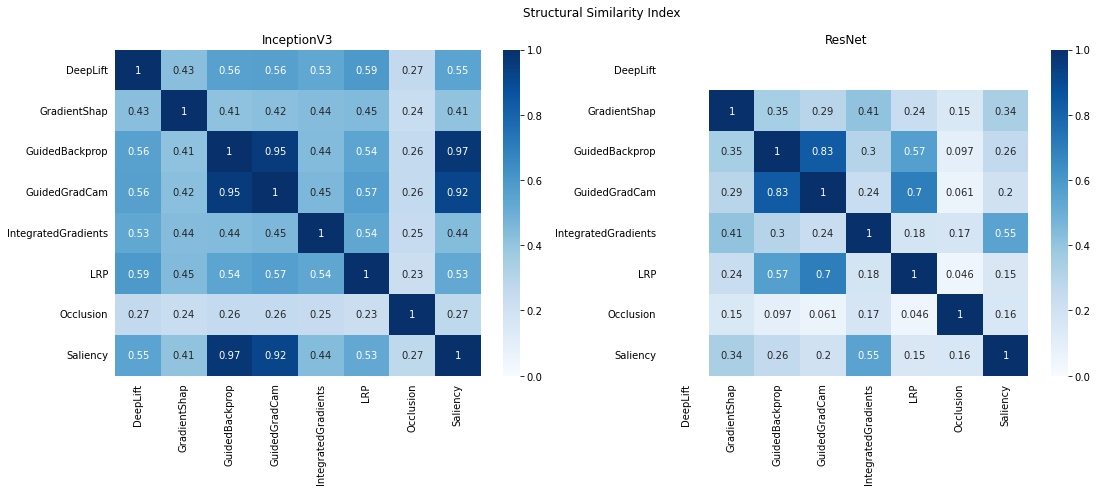

In [26]:
fig_ssim, axes_ssim = visualize_many(heatmap_ssim, metric_name='Structural Similarity Index', **options)
fig_ssim.savefig('figures/ssim.png', bbox_inches='tight')
plt.show()

# Visualize sample of saliency maps

In [27]:
def visualize_sample_saliency(x, masks, explanations, blackbox, methods, index):
    num_methods = len(methods)
    row, col = 2, math.ceil(num_methods / 2) + 1
    fig, axes = plt.subplots(row, col, figsize=(26, 10))
    
    axes[0][0].imshow(x[index].permute(1, 2, 0))
    axes[1][0].imshow(masks[index], cmap='gray')
    
    for i, m in enumerate(methods):
        p = sns.heatmap(
            normalize(explanations[blackbox][m][index].abs().detach().numpy()),
            ax=axes[(i + 1) // col][1 + (i % (col-1))],
            annot=False,
            cbar=False,
            cmap='viridis'
        ).set(
            xticklabels=[],
            yticklabels=[],
            title=m
        )

        plt.legend([], [], frameon=False)

    for i, ax in enumerate(axes.flat):
        ax.tick_params(axis='both', which='both', bottom=False, top=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= num_methods:
            ax.axis('off')
        
    return fig, axes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


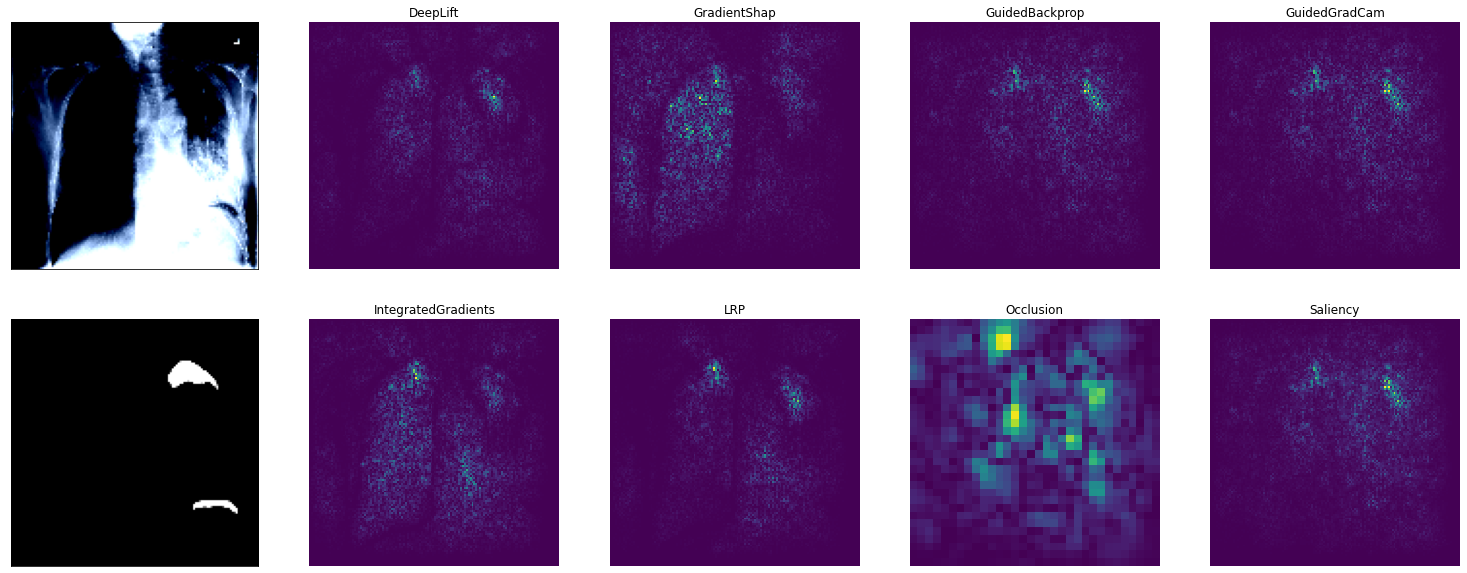

In [28]:
fig_inceptionv3, _ = visualize_sample_saliency(x, masks, explanations, 'InceptionV3', methods, 0)
fig_inceptionv3.savefig('figures/shape-comparison-inceptionv3.png', bbox_inches='tight')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\mdnam\.local\opt\miniconda\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\mdnam\.local\opt\miniconda\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


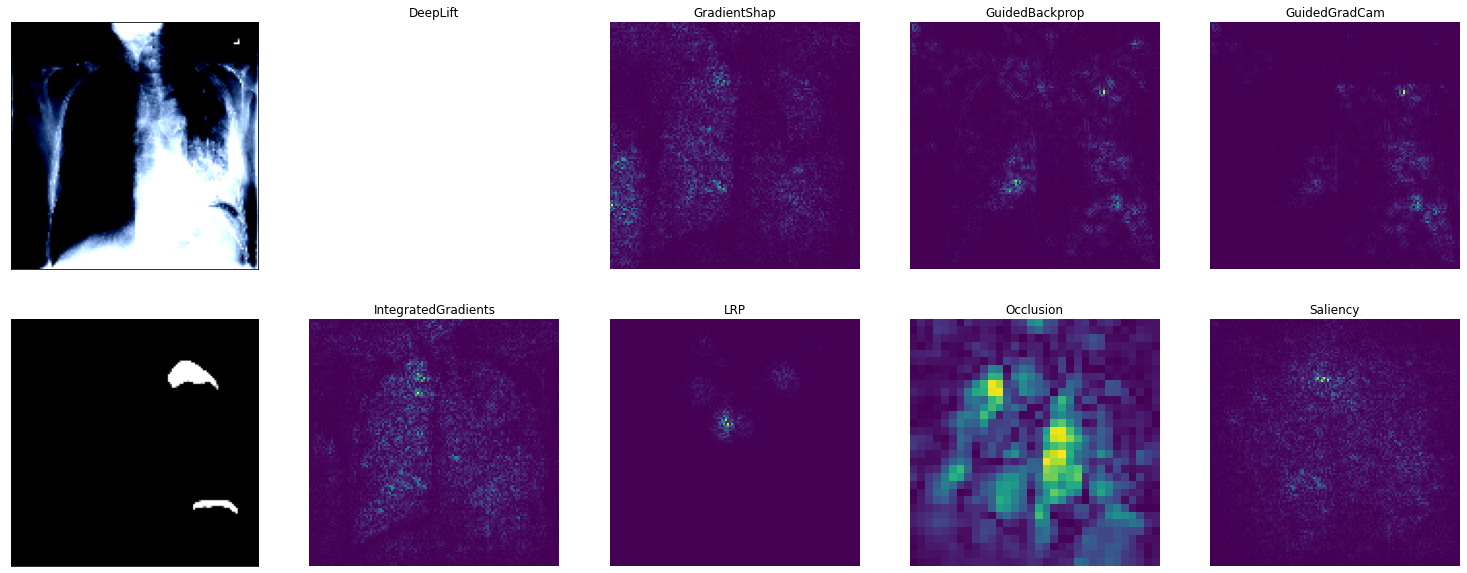

In [29]:
fig_resnet, _ = visualize_sample_saliency(x, masks, explanations, 'ResNet', methods, 0)
fig_resnet.savefig('figures/shape-comparison-resnet.png', bbox_inches='tight')
plt.show()

# Visualize saliency maps value distribution

In [30]:
def plot_saliency_distribution(explanations, blackbox, methods):
    num_methods = len(methods)
    fig, axes = plt.subplots(4, 2, figsize=(8, 10), sharey=True)
    fig.tight_layout(w_pad=1, h_pad=1.5)
    
    for i, ax in enumerate(axes.flat):
        if i >= num_methods:
            ax.axis('off')
            continue

        topk = explanations[blackbox][methods[i]]
        topk = topk[get_top_k(topk, 1000)]
        sns.histplot(topk.numpy(), ax=ax).set(title=methods[i])
        
    return fig, axes

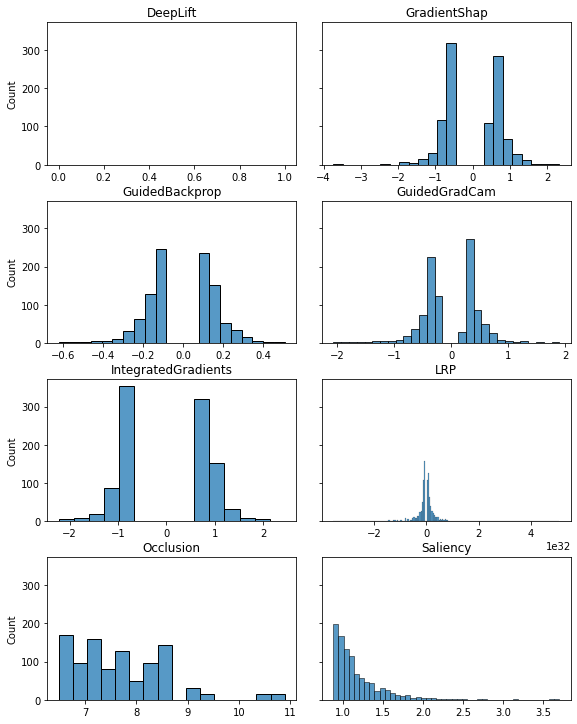

In [31]:
fig_dis_resnet, _ = plot_saliency_distribution(explanations, 'ResNet', methods)
fig_dis_resnet.savefig('figures/saliency-maps-value-distribution-resnet.png', bbox_inches='tight')
plt.show()

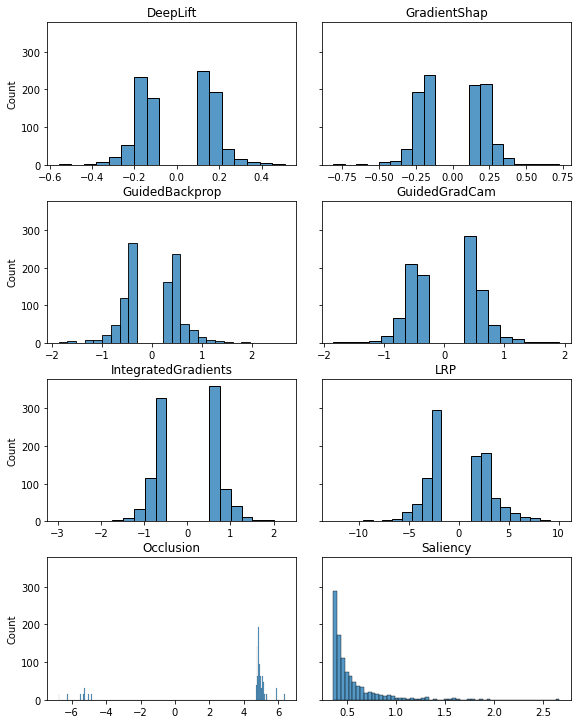

In [32]:
fig_dis_inceptionv3, _ = plot_saliency_distribution(explanations, 'InceptionV3', methods)
fig_dis_inceptionv3.savefig('figures/saliency-maps-value-distribution-inceptionv3.png', bbox_inches='tight')
plt.show()